# subsub
## Fixing the data and looking at it

Natalie Gosnell  
July 5, 2016

Michael Gully-Santiago  
July 7, 2016

Making sure re-reduced spectra looks right and checking wave and variance info

## New data
S1063 in M67. All H-band data in "SDCH_20150425_0064.spec_a0v.fits". Variance in "SDCH_20150425_0064.variance.fits". Located in ../data/raw/

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
sns.set_context('notebook')

In [3]:
!ls -1 ../data/raw/

S1063_o110.fits
S1063_o113.fits
S1063_o115.fits
SDCH_20150425_0064.spec_a0v.fits
SDCH_20150425_0064.variance.fits


In [4]:
hdu = fits.open("../data/raw/SDCH_20150425_0064.spec_a0v.fits")

In [5]:
var = fits.open("../data/raw/SDCH_20150425_0064.variance.fits")

In [6]:
hdu.info()

Filename: ../data/raw/SDCH_20150425_0064.spec_a0v.fits
No.    Name         Type      Cards   Dimensions   Format
0    SPEC_DIVIDE_A0V  PrimaryHDU     183   (2048, 28)   float64   
1    WAVELENGTH  ImageHDU       184   (2048, 28)   float64   
2    TGT_SPEC    ImageHDU       184   (2048, 28)   float32   
3    A0V_SPEC    ImageHDU       184   (2048, 28)   float32   
4    VEGA_SPEC   ImageHDU       184   (2048, 28)   float64   


In [7]:
var.info()

Filename: ../data/raw/SDCH_20150425_0064.variance.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     181   (2048, 28)   float32   


In [8]:
dat = hdu[0]
wav = hdu[1]

In [9]:
o110 = 12  
o113 = 15  
o115 = 17

In [10]:
dat.data[o110]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

### Derive the A0 corrected $\sigma$ from the variance

In [55]:
scale_factor = hdu[3].data[o115]/hdu[4].data[o115]

In [70]:
#plt.plot(hdu[1].data[o115], hdu[2].data[o115])
#plt.plot(hdu[1].data[o115], np.sqrt(var[0].data[o115]))
#plt.ylim(0, 8000)

In [71]:
#np.nanmax(hdu[2].data[o115]/np.sqrt(var[0].data[o115]))*np.sqrt(3.5)

In [72]:
#plt.plot(hdu[1].data[o115], hdu[2].data[o115]/scale_factor)
#plt.plot(hdu[1].data[o115], hdu[0].data[o115], alpha=0.5)
#plt.ylim(0, 8.0e5)

In [67]:
sigma_raw = np.sqrt(var[0].data[o115])
sig_scaled = sigma_raw/scale_factor

In [69]:
signal = hdu[2].data[o115]/scale_factor
noise = sig_scaled
median_S_N = np.nanmedian(signal/noise)
print("Median Signal to Noise Ratio: {:0.1f} per pixel".format(median_S_N))

Median Signal to Noise Ratio: 40.0 per pixel


#### Yep, we have nans...not sure the best way to deal with this. Below is a possibility, but you might have a nicer method.

## Order 110

In [11]:
flux110 = dat.data[o110]
fluxcut110 = flux110[~np.isnan(flux110)]
fluxcut110

array([ -584440.51238106,  2408426.27221528, -2065187.58952561, ...,
         345491.46041362,   386392.03504595,   410931.53738583])

In [12]:
wave110 = wav.data[o110]
wavecut110 = wave110[~np.isnan(flux110)]
wavecut110

array([ 1.61714742,  1.61716003,  1.61717264, ...,  1.63975213,
        1.63976211,  1.63977209])

In [13]:
sigma = var[0]

In [14]:
sig110 = sigma.data[o110]
sigcut110 = sig110[~np.isnan(flux110)]
sigcut110

array([ 1592.81896973,  1824.42602539,  1722.28039551, ...,  2549.68652344,
        2501.43261719,  2494.15185547], dtype=float32)

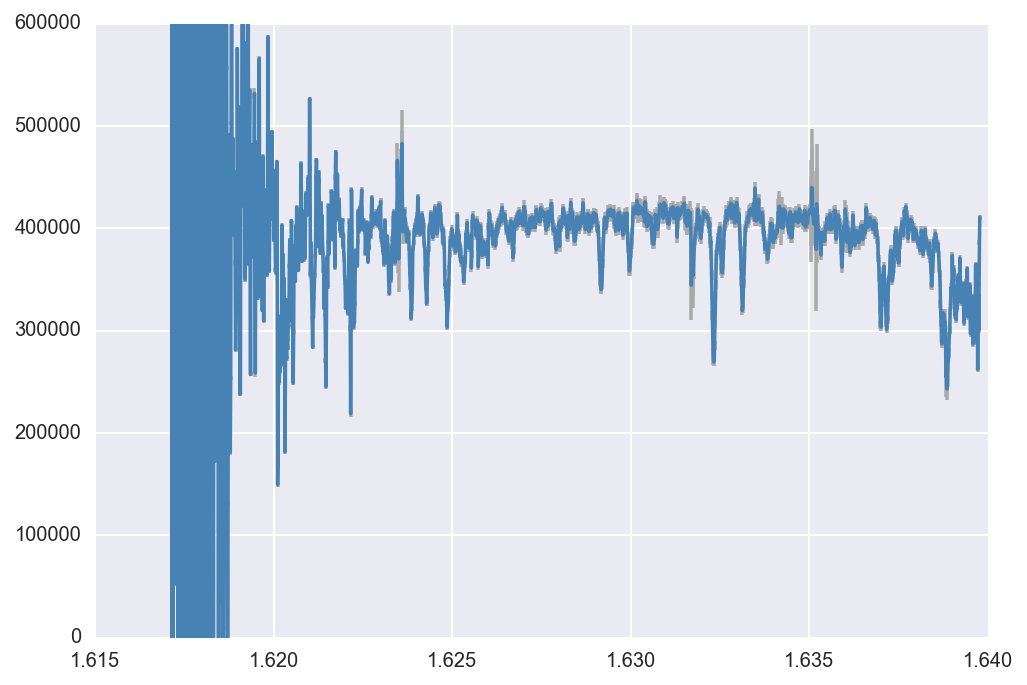

In [15]:
plt.errorbar(wavecut110,fluxcut110,yerr=sigcut110,capsize=0,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,6e5)
plt.show()

#### Not sure if we care about trimming noise intelligently or we should just cut off by eye (e.g., everything short of ~1.623 in this order) ...leaving it for now

## Order 113

In [16]:
flux113 = dat.data[o113]
fluxcut113 = flux113[~np.isnan(flux113)]
wave113 = wav.data[o113]
wavecut113 = wave113[~np.isnan(flux113)]
sig113 = sigma.data[o113]
sigcut113 = sig113[~np.isnan(flux113)]

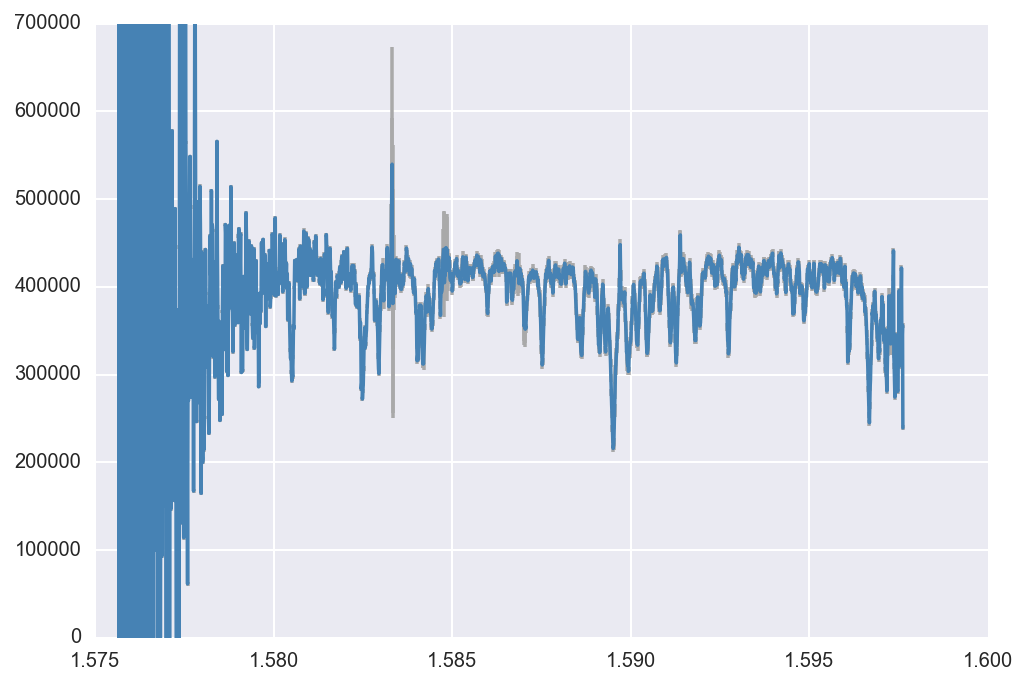

In [17]:
plt.errorbar(wavecut113,fluxcut113,yerr=sigcut113,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,7e5)
plt.show()

## Order 115

In [73]:
flux115 = dat.data[o115]
fluxcut115 = flux115[~np.isnan(flux115)]
wave115 = wav.data[o115]
wavecut115 = wave115[~np.isnan(flux115)]
sig115 = sig_scaled # need to use the scaled sigma
sigcut115 = sig115[~np.isnan(flux115)]

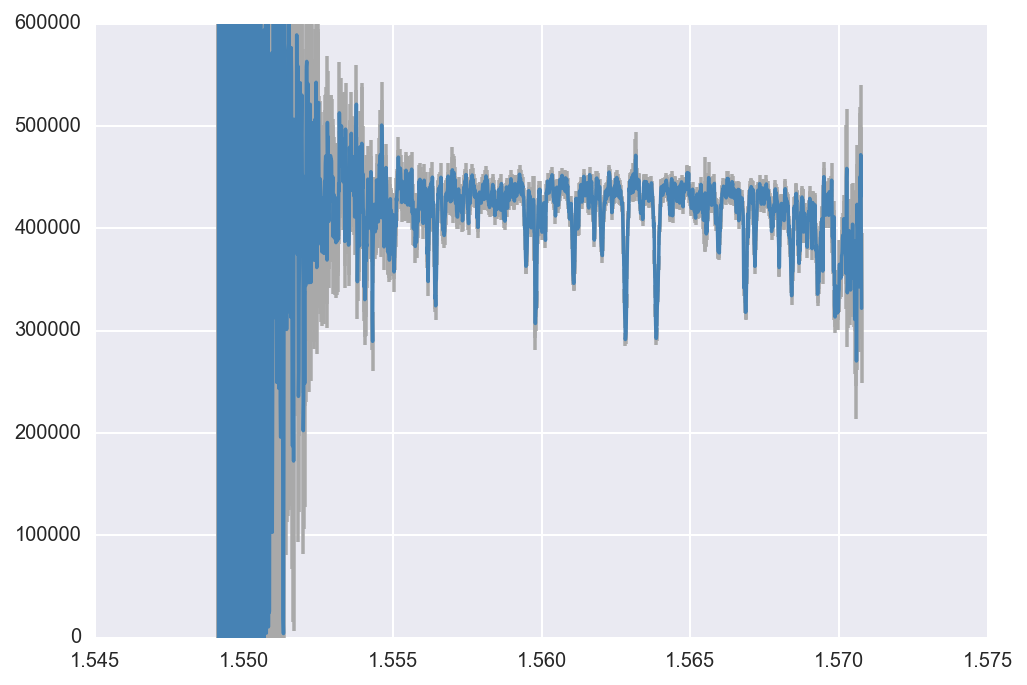

In [75]:
plt.errorbar(wavecut115,fluxcut115,yerr=sigcut115,color="steelblue",
             ecolor="darkgray")
plt.ylim(0,6e5)
plt.show()

## Data munging

- ~~Trim NaNs~~
- ~~Trim really noisy section~~
- ~~Scale the absolute values down to ~1.0 just for ease of plotting~~
- ~~Convert variance to sigma (if it's not already?)~~
- Convert wavelength to angstroms

### Trim NaNs

In [20]:
wavecut115.shape, fluxcut115.shape, sigcut115.shape

((2040,), (2040,), (2040,))

In [21]:
bi = (fluxcut115 != fluxcut115) | (sigcut115 != sigcut115)
len(bi), bi.sum()

(2040, 0)

Ok, so no more `NaN`s, that's good.

### Trim really noisy section and convert $\mu$m to Angstroms.

In [77]:
gi = (wavecut115 > 1.555) & (wavecut115 < 1.570)

In [78]:
gi.sum()

1455

In [79]:
wl = wavecut115
fl = fluxcut115
sg = sigcut115

In [84]:
fls_out = fl[gi]
sig_out = sg[gi]
wls_out = wl[gi]*10000.0
msk_out = np.ones(len(wls_out), dtype=int)

### Convert variance to sigma (if it's not already?)

This is done above.

### Scale the absolute values down to ~1.0 just for ease of plotting

In [85]:
med_fls = np.median(fls_out)
fls_out = fls_out / med_fls
sig_out = sig_out / med_fls

<Container object of 3 artists>

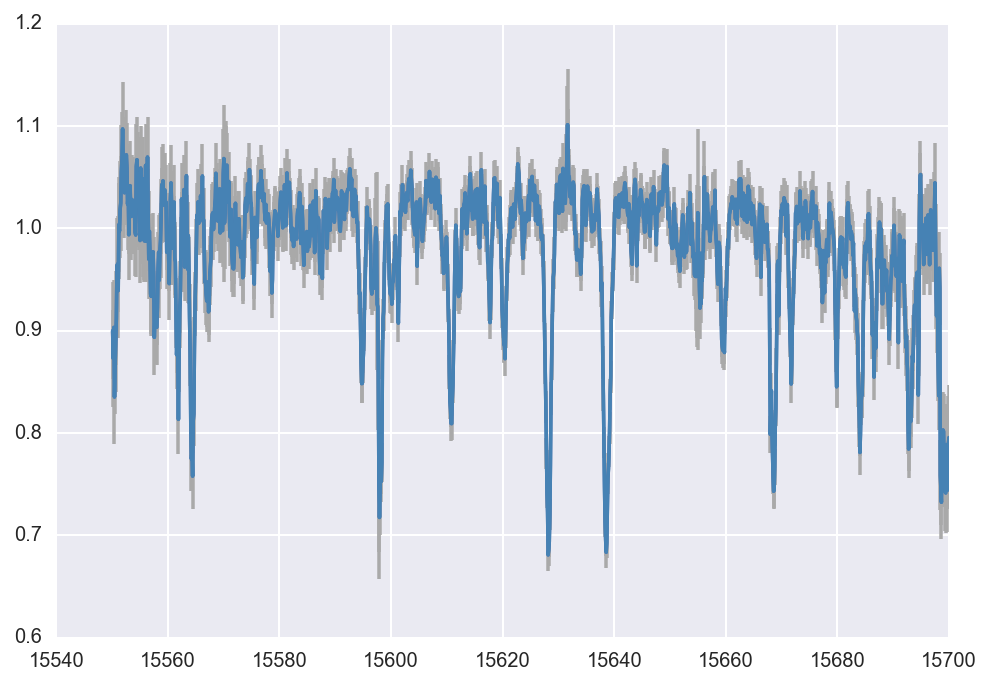

In [86]:
plt.plot(wls_out, fls_out)
plt.errorbar(wls_out,fls_out,yerr=sig_out,color="steelblue",
             ecolor="darkgray")

In [87]:
! mkdir ../data/reduced

mkdir: ../data/reduced: File exists


In [88]:
import h5py

In [89]:
m = 115
out_name = '../data/reduced/subsub_m115.hdf5'.format(m)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15550  -  15700   ../data/reduced/subsub_m115.hdf5


## I only did m = 115.  Need to go back and clean the sigma vector for the other orders.

The end for now.